In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/books-dataset/intents.json
/kaggle/input/books-dataset/data.csv


In [2]:
df = pd.read_csv('/kaggle/input/books-dataset/data.csv')

# Get the shape of the dataset (number of rows and columns)
num_rows, num_cols = df.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_cols)

# Get the list of column names
column_names = df.columns.tolist()
print("Column names:", column_names)

# Display a sample of the dataset
sample_data = df.head(10)  # Change the number to display more or fewer rows
print("Sample data:")
print(sample_data)

# Get basic statistics about the dataset
data_stats = df.describe()
print("Dataset statistics:")
print(data_stats)

Number of rows: 6810
Number of columns: 12
Column names: ['isbn13', 'isbn10', 'title', 'subtitle', 'authors', 'categories', 'thumbnail', 'description', 'published_year', 'average_rating', 'num_pages', 'ratings_count']
Sample data:
          isbn13      isbn10                   title  \
0  9780002005883  0002005883                  Gilead   
1  9780002261982  0002261987            Spider's Web   
2  9780006163831  0006163831            The One Tree   
3  9780006178736  0006178731          Rage of angels   
4  9780006280897  0006280897          The Four Loves   
5  9780006280934  0006280935     The Problem of Pain   
6  9780006353287  0006353282        An Autobiography   
7  9780006380832  0006380832  Empires of the Monsoon   
8  9780006470229  000647022X    The Gap Into Madness   
9  9780006472612  0006472613      Master of the Game   

                                         subtitle  \
0                                             NaN   
1                                         A No

### **Distribution of Ratings**

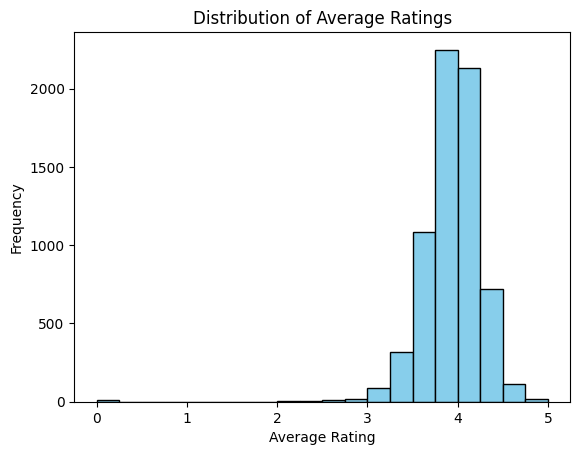

In [3]:
import matplotlib.pyplot as plt

# Histogram of ratings
plt.hist(df['average_rating'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Average Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()


### **Number of Pages vs. Ratings Count**

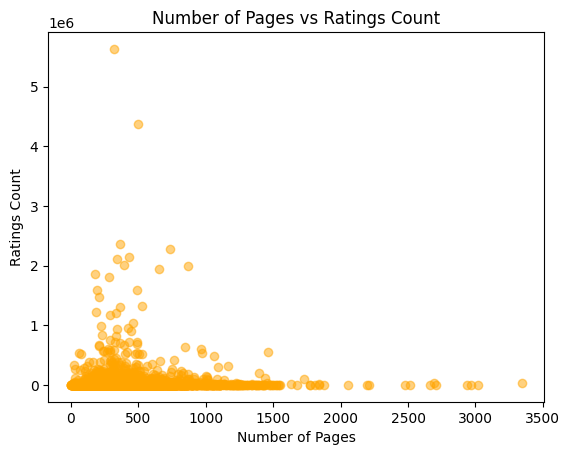

In [4]:
# Scatter plot of number of pages vs ratings count
plt.scatter(df['num_pages'], df['ratings_count'], alpha=0.5, color='orange')
plt.title('Number of Pages vs Ratings Count')
plt.xlabel('Number of Pages')
plt.ylabel('Ratings Count')
plt.show()


### **Published Year Distribution**

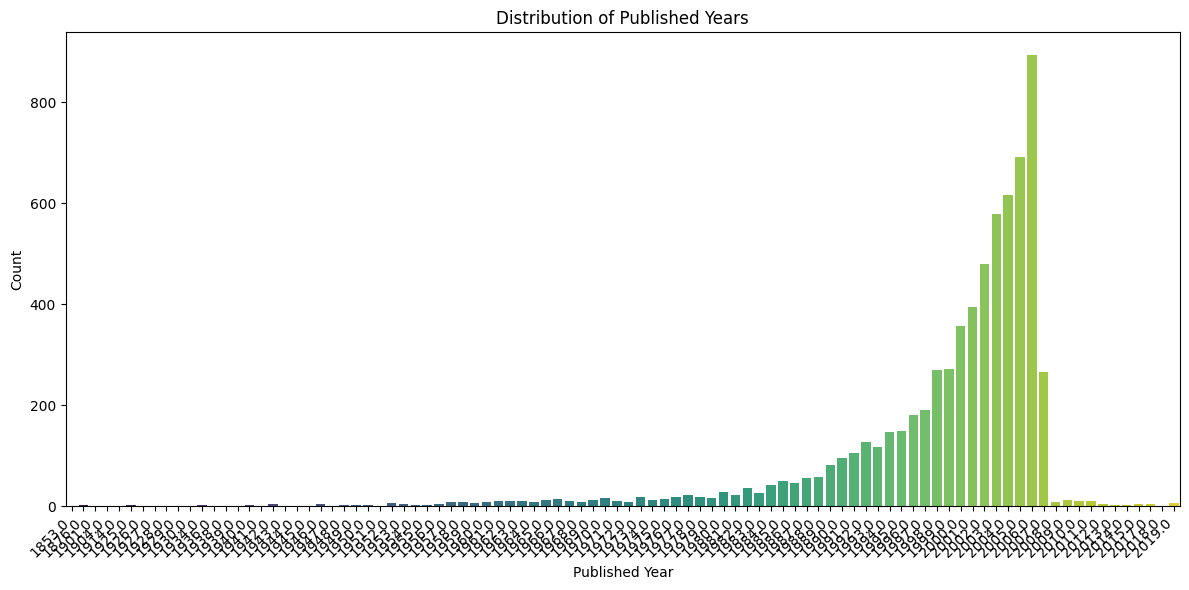

In [5]:
import seaborn as sns
# Count plot of published years with rotated x-axis labels
plt.figure(figsize=(12, 6))
sns.countplot(x=df['published_year'], palette='viridis')
plt.title('Distribution of Published Years')
plt.xlabel('Published Year')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of rotated labels
plt.show()


### **Distribution of Book Categories**

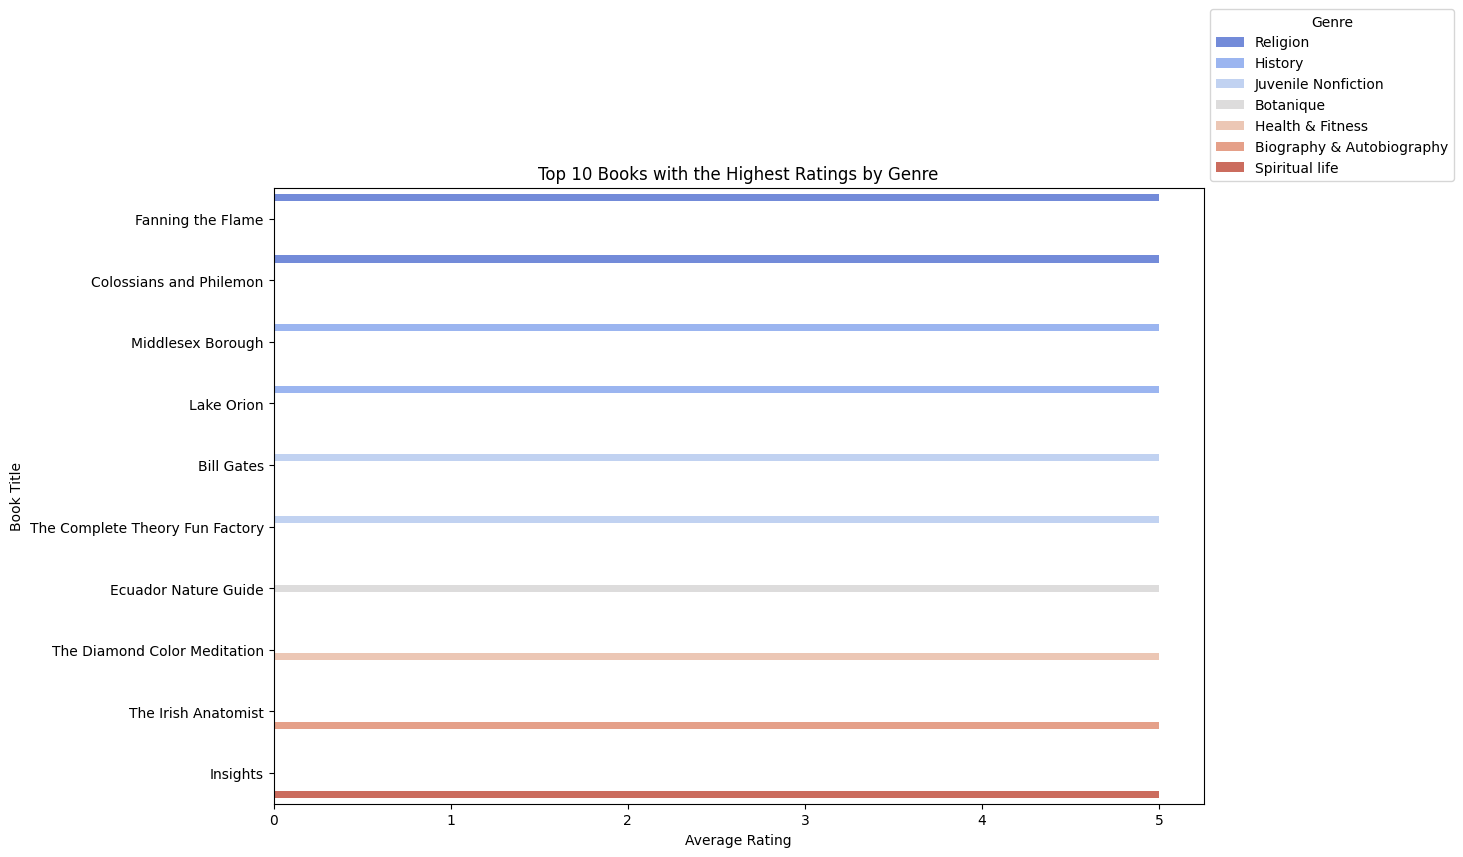

In [6]:
# Identify top 10 books with the highest ratings
top_rated_books = df.nlargest(10, 'average_rating')

# Bar plot for top 10 books by rating and genre
plt.figure(figsize=(12, 8))
sns.barplot(x='average_rating', y='title', hue='categories', data=top_rated_books, palette='coolwarm')
plt.title('Top 10 Books with the Highest Ratings by Genre')
plt.xlabel('Average Rating')
plt.ylabel('Book Title')
plt.legend(title='Genre', bbox_to_anchor=(1, 1))
plt.show()


### **Distribution of Authors**

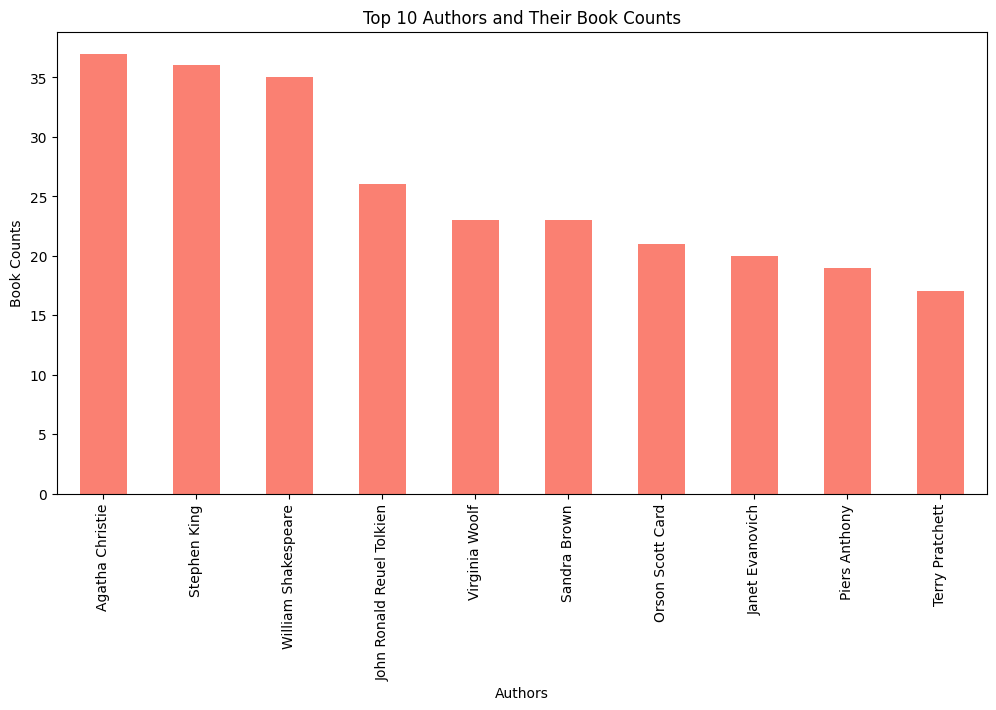

In [7]:
# Top authors and their book counts
top_authors = df['authors'].value_counts().head(10)
plt.figure(figsize=(12, 6))
top_authors.plot(kind='bar', color='salmon')
plt.title('Top 10 Authors and Their Book Counts')
plt.xlabel('Authors')
plt.ylabel('Book Counts')
plt.show()


# **Recommendation Code**

## **Data Preprocessing:**

In [8]:
# Handle missing values
df['subtitle'].fillna('', inplace=True)
df['description'].fillna('', inplace=True)

# Convert data types if necessary
df['published_year'] = df['published_year'].astype('int', errors='ignore')

# Tokenize and clean text data
# You can use libraries like NLTK or spaCy for text processing


Explanation:

Use fillna() to handle missing values in specific columns.
Convert data types using astype() if necessary.
Tokenize and clean text data using NLP libraries like NLTK or spaCy.

## **Feature Engineering:**

In [9]:
# Combine relevant information
df['full_text'] = df['title'] + ' ' + df['subtitle'] + ' ' + df['description']


Explanation:

Create a new feature (full_text) by combining relevant information from title, subtitle, and description.

## **Content-Based Filtering:**

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['full_text'])

# Compute similarity scores
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)


Explanation:

Use TF-IDF vectorization to represent text as vectors.
Compute similarity scores using the linear kernel.

## **Build a Recommendation Engine:**

In [11]:
pip install gensim


Note: you may need to restart the kernel to use updated packages.


In [12]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Tokenize and train Word2Vec model
tokenized_text = df['full_text'].apply(word_tokenize)
word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, workers=4)


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
import numpy as np

def embed_text(text):
    # Create an embedding for a given text by averaging word embeddings
    words = word_tokenize(text)
    word_embeddings = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    
    if not word_embeddings:
        return np.zeros(word2vec_model.vector_size)
    
    return np.mean(word_embeddings, axis=0)

# Add word embeddings as a new feature
df['word_embeddings'] = df['full_text'].apply(embed_text)

# Compute similarity scores using cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarities_word2vec = cosine_similarity(list(df['word_embeddings']))


* embed_text is a function that takes a piece of text as input and returns a word embedding for that text.

* It tokenizes the text using word_tokenize from NLTK.
* For each word in the text, it checks if the word exists in the Word2Vec model's vocabulary (word2vec_model.wv).
* If a word has an embedding, it is added to the word_embeddings list.
* If no valid embeddings are found, it returns a zero vector of the same size as the Word2Vec vectors.
* Otherwise, it calculates the average of the word embeddings along the specified axis (axis=0) to get the final embedding for the entire text.

* The embed_text function is applied to each row of the 'full_text' column in the DataFrame using apply.
* The resulting word embeddings are stored in a new column called 'word_embeddings'.

* The cosine_similarity function from scikit-learn is used to compute pairwise cosine similarity scores between word embeddings.
* The word_embeddings column is converted to a list and passed to cosine_similarity.
* The resulting matrix (cosine_similarities_word2vec) contains the cosine similarity scores between each pair of texts in the dataset.

In [14]:
def get_recommendations_word2vec(book_title):
    idx = df[df['title'] == book_title].index[0]
    sim_scores = list(enumerate(cosine_similarities_word2vec[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]  # Top 10 recommendations (excluding itself)

    book_indices = [i[0] for i in sim_scores]
    return df['title'].iloc[book_indices]


Explanation:

Define a function (get_recommendations) to retrieve top recommendations based on a given book title.
Use the computed similarity scores to find the most similar books.

In [15]:
# Example usage:
book_title = 'Star Wars'
recommendations_word2vec = get_recommendations_word2vec(book_title)
print(recommendations_word2vec)

3689              Vesco from Wall Street to Castro's Cuba
6002                 The Hitchhiker's Guide to the Galaxy
4979                            The Labyrinth of Solitude
3260            A New Collection of Three Complete Novels
6296    The American Heritage New History of the Civil...
3958                               Stars in Their Courses
42          The Lord of the Rings, the Return of the King
6214                                 The South Beach Diet
2683                  Guardians of Ga'Hoole #4: The Siege
5171                                    The Shadow Rising
Name: title, dtype: object


In [16]:
# Example usage:
book_title = 'The Lord of the Rings, the Return of the King'
recommendations_word2vec = get_recommendations_word2vec(book_title)
print(recommendations_word2vec)

3260        A New Collection of Three Complete Novels
2153                                       Paris 1919
1635                            The Fantastic Vampire
3769            The Best American Travel Writing 2006
6375    The Complete Idiot's Guide to World Religions
1944                              The Age of Extremes
6002             The Hitchhiker's Guide to the Galaxy
3186                                      The Odyssey
5071                                  So Far from God
6101                                  Complete Essays
Name: title, dtype: object
